In [33]:
import time
import numpy as np
import matplotlib.pyplot as plt
from stat_phys import MB_Sampler1D
from ipywidgets import interact
import ipywidgets as widgets
from matplotlib.patches import Rectangle
import asyncio
import plotly.graph_objs as go
from IPython.display import display

In [49]:
kb = 1.38e-23 #J/K
m = 6.65e-27 #Kg
t= 300 #K
num_particles = 10000

In [50]:
def maxwell_boltzmann_speed(v,m,kb,t):
	d1 = 2*np.pi*kb*t
	c1 = (m/d1)**(3/2)
	d2 = 2*kb*t
	c2 = -(m*v**2)/d2
	return 4*np.pi*v**2*c1*np.exp(c2)

# The Free Expansion Problem

We have a box with some intial number of particles completely isolated but next to some volume which is in vacuum. If we at some time allow the particles to cross over into the volume that is in vacuum, what does the velocity distribution look like over time in that region.

In [51]:
box_x = 10
box_y = 10
box_z = 10

## Generating the Particles

The first thing we have to do is generate the particles and their velocities. What we will do is create an array of positions which will be chosen uniformly and at random from inside the box. We will also initialize random velocities chosen from the maxwell distribution.

In [52]:
dx = 1000

mb = MB_Sampler1D(m,kb,t)
mb.metropolis_hastings_sampler(dx)

xs = np.random.rand(num_particles)*box_x
ys = np.random.rand(num_particles)*box_y
zs = np.random.rand(num_particles)*box_z

vxs = mb.sampler(num_particles)
vys = mb.sampler(num_particles)
vzs = mb.sampler(num_particles)

positions = np.column_stack((xs,ys,zs))
velocities = np.column_stack((vxs,vys,vzs))

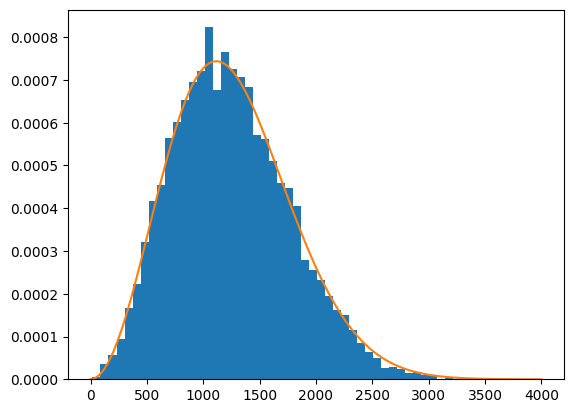

In [53]:
speed_func = lambda v : maxwell_boltzmann_speed(v,m,kb,t)

speeds = np.linalg.norm(velocities,axis=1)
plt.hist(speeds,density=True,bins=50)
x_vals = np.linspace(0,4000,100)
y_vals = speed_func(x_vals)
plt.plot(x_vals,y_vals)
plt.show()

## Updating the positions

To update the positions we have to define some time step $dt$ which we will use when integrating the velocity. Additionally we have to make it so that if a particle crosses a boundary, their velocity is flipped and their position is clamped inside the box.

In [54]:
def take_time_step(position, velocity, dt):
	#Update the positions
	new_position = position + velocity * dt
	#Make a new set of velocities
	new_velocity = velocity
	if new_position[0] > box_x:
		#Compute how far beyond the box the particle has traveled
		extra = new_position[0] - box_x
		#Compute how many box lengths beyond the box the particle has traveled
		q, r = divmod(extra,box_x)
		#Adjust the position to have traveled that far inside the box
		if q%2 == 0:
			#The particle will have last reflected off the right wall
			new_position[0] = box_x - r
		else:
			#The particle will have reflected off the left wall
			new_position[0] = r
		#Reflect the velocity based on how many times the particle has bounced
		new_velocity[0] = (-1)**(q+1)*new_velocity[0]
	if new_position[0] < 0:
		#Adjust the position to have traveled that far inside the box
		extra = -new_position[0]
		#Compute how many box lengths beyond the box the particle has traveled
		q, r = divmod(extra,box_x)
		#Adjust the position to have traveled that far inside the box
		if q%2 == 0:
			#The particle will have last reflected off the left wall
			new_position[0] = r
		else:
			#The particle will have reflected off the left wall
			new_position[0] = box_x - r
		#Reflect the velocity based on how many times the particle has bounced
		new_velocity[0] = (-1)**(q+1)*new_velocity[0]
	if new_position[1] > box_y:
		#Compute how far beyond the box the particle has traveled
		extra = new_position[1] - box_y
		#Compute how many box lengths beyond the box the particle has traveled
		q, r = divmod(extra,box_y)
		#Adjust the position to have traveled that far inside the box
		if q%2 == 0:
			#The particle will have last reflected off the right wall
			new_position[1] = box_y - r
		else:
			#The particle will have reflected off the left wall
			new_position[1] = r
		#Reflect the velocity based on how many times the particle has bounced
		new_velocity[1] = (-1)**(q+1)*new_velocity[1]
	if new_position[1] < 0:
		#Adjust the position to have traveled that far inside the box
		extra = -new_position[1]
		#Compute how many box lengths beyond the box the particle has traveled
		q, r = divmod(extra,box_y)
		#Adjust the position to have traveled that far inside the box
		if q%2 == 0:
			#The particle will have last reflected off the left wall
			new_position[1] = r
		else:
			#The particle will have reflected off the left wall
			new_position[1] = box_y - r
		#Reflect the velocity based on how many times the particle has bounced
		new_velocity[1] = (-1)**(q+1)*new_velocity[1]
	if new_position[2] > box_z:
		#Compute how far beyond the box the particle has traveled
		extra = new_position[2] - box_z
		#Compute how many box lengths beyond the box the particle has traveled
		q, r = divmod(extra,box_z)
		#Adjust the position to have traveled that far inside the box
		if q%2 == 0:
			#The particle will have last reflected off the right wall
			new_position[2] = box_z - r
		else:
			#The particle will have reflected off the left wall
			new_position[2] = r
		#Reflect the velocity based on how many times the particle has bounced
		new_velocity[2] = (-1)**(q+1)*new_velocity[2]
	if new_position[2] < 0:
		#Adjust the position to have traveled that far inside the box
		extra = -new_position[2]
		#Compute how many box lengths beyond the box the particle has traveled
		q, r = divmod(extra,box_z)
		#Adjust the position to have traveled that far inside the box
		if q%2 == 0:
			#The particle will have last reflected off the left wall
			new_position[2] = r
		else:
			#The particle will have reflected off the left wall
			new_position[2] = box_z - r
		#Reflect the velocity based on how many times the particle has bounced
		new_velocity[2] = (-1)**(q+1)*new_velocity[2]
	return (new_position,new_velocity)

In [55]:
def update_particles(dt):
	for i in range(num_particles):
		position = positions[i]
		velocity = velocities[i]
		np, nv = take_time_step(position,velocity,dt)
		positions[i] = np
		velocities[i] = nv

In [56]:
out = widgets.Output()

dt_text = widgets.BoundedFloatText(value = 1e-4,min = 1e-6, max = 10, description="Delta T")
button = widgets.Button(description="Update Positions")

def update_positions(*args):
	with out:
		out.clear_output(wait=True)
		update_particles(dt_text.value)
		speed = np.linalg.norm(velocities, axis=1)

		# avoid divide-by-zero
		speed[speed == 0] = 1.0

		v_hat = velocities / speed[:, None]


		plt.scatter(positions[:,0],positions[:,2])
		plt.quiver(positions[:,0],positions[:,2],v_hat[:,0],v_hat[:,2],scale = 40,color="Red")
		plt.show()
update_positions()

button.on_click(update_positions)
display(dt_text,button,out)

BoundedFloatText(value=0.0001, description='Delta T', max=10.0, min=1e-06)

Button(description='Update Positions', style=ButtonStyle())

Output()

## Removing the Barrier

Currently there is a z barrier at $z = 10$. We would like to instantaneously remove this barrier and then to see what happens when the particles are allowed to traverse to a new z_max. Additionally we would like to see the speed dsitribution of both sides of the container.

In [57]:
box_z_new = 20
time_per_frame = 0.5 #In seconds

In [58]:
# Create FigureWidget
fig = go.FigureWidget()
fig.update_layout(title="Particles in a Box", xaxis_title="X", yaxis_title="Z")
fig2 = go.FigureWidget()
fig2.update_layout(title="Histogram of Particles in region1", xaxis_title="X", yaxis_title="Probability Density")
fig3 = go.FigureWidget()
fig3.update_layout(title="Histogram of Particles in region2", xaxis_title="X", yaxis_title="Probability Density")

# --- Buttons to start and stop the loop ---
start_button = widgets.Button(description="Start Running", button_style='success')
stop_button = widgets.Button(description="Stop Running", button_style='danger')
pause_button = widgets.Button(description="toggle pause")
remove_wall_button = widgets.Button(description="Remove Wall")

buttons = widgets.VBox([start_button,pause_button,stop_button,remove_wall_button,dt_text])

display(widgets.HBox([fig,buttons]),widgets.HBox([fig2,fig3]))

local_z = box_z

# Global flag for running state
running = False
paused = False
wall_removed = False
elapsed = 0


# Async update loop
async def update_loop():
	global running, paused, wall_removed, elapsed
	while running:
		if not paused:
			if wall_removed:
				elapsed += dt_text.value
			update_particles(dt_text.value)
			fig.data = []  # Clear previous traces
			fig2.data = []
			fig3.data = []
			fig.layout.shapes = []
			fig.update_layout(
				title="Particles in a Box at time (t="+f"{elapsed:.6f}"+"s)",
				xaxis=dict(range=[-1, box_x+1]),
				yaxis=dict(range=[-1, box_z+1]))
			fig.add_shape(
				type="rect",  # Type of the shape (rectangle)
				x0=0, y0=0,  # Bottom-left corner (x0, y0)
				x1=box_x, y1=box_z,   # Top-right corner (x1, y1)
				line=dict(color="RoyalBlue", width=3),  # Rectangle border color and width
				fillcolor="rgba(0, 0, 0, 0)",  # Fill color with transparency
			)

			speeds = np.linalg.norm(velocities,axis=1)

			speeds_region1 = speeds[positions[:,2] <= local_z]
			speeds_region2 = speeds[positions[:,2] > local_z]

			# Add new scatter plot (random data for example)
			fig.add_scatter(x=positions[:,0], y=positions[:,2], mode='markers')
			
			fig2.add_scatter(x=x_vals,y=y_vals,mode="lines",name="Maxwell Boltzmann")
			fig2.add_trace(go.Histogram(
				x=speeds_region1,  # The data to plot
				nbinsx=50,  # Number of bins
				histnorm="probability density",
				name="Particle Speed Distribution",
				marker=dict(color='royalblue', opacity=0.7),  # Customize the color and opacity
			))

			fig3.add_scatter(x=x_vals,y=y_vals,mode="lines", name = "Maxwell Boltzmann")
			fig3.add_trace(go.Histogram(
				x=speeds_region2,  # The data to plot
				nbinsx=50,  # Number of bins
				histnorm="probability density",
				name="Particle Speed Distribution",
				marker=dict(color='royalblue', opacity=0.7),  # Customize the color and opacity
			))
			

			# Allow the notebook to update the figure before continuing
		await asyncio.sleep(time_per_frame)

# Start the loop
def start_running(*args):
	global running
	if not running:
		running = True
		asyncio.create_task(update_loop())  # Start the update loop asynchronously

# Stop the loop
def stop_running(*args):
	global running, box_z, wall_removed
	running = False
	box_z = local_z
	wall_removed = False
	elapsed = 0


def toggle_pause(*args):
	global paused
	paused = not paused

def remove_wall(*args):
	global box_z, wall_removed
	box_z = box_z_new
	wall_removed = True



start_button.on_click(start_running)
stop_button.on_click(stop_running)
pause_button.on_click(toggle_pause)
remove_wall_button.on_click(remove_wall)


    'data': [],
    'layout': {'template': '...',
               'title': {'text…

    'data': [],
    'layout': {'template': '...',
               'title': {'text…